In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
np.set_printoptions(precision=2)

In [2]:
class MLP():
    def __init__(self, listOfLayer=[2, 3, 2], activationFunction="ReLU"):
        self.numLayers = len(listOfLayer)
        self.layers = [{} for i in range(self.numLayers)]
        self.activationFunction = activationFunction
        
        for i in range(1, self.numLayers):
            self.layers[i]["W"] = np.random.randn(listOfLayer[i], listOfLayer[i-1])
            self.layers[i]["b"] = np.random.randn(listOfLayer[i], 1)
        self.lossList = []
        return
            
    def forward(self, x, bs):
        self.layers[0]["a"] = np.copy(x)
        for i in range(1, self.numLayers):
            self.layers[i]["z"] = self.layers[i]["W"].dot(self.layers[i-1]["a"]) + self.layers[i]["b"]
            actType = "sigmoid" if i == self.numLayers - 1 else self.activationFunction
            self.layers[i]["a"] = self.activation(self.layers[i]["z"], actType)
        self.p = self.softmax(self.layers[-1]["a"])
        self.yHat = np.zeros(self.p.shape, dtype=int)
        for j, i in enumerate(self.p.argmax(axis=0)):
            self.yHat[i, j] = 1
        return
    
    def activation(self, z, actType="sigmoid"):
        if actType == "sigmoid":
            a = 1.0 / (1.0 + np.exp(-z))
        elif actType == "ReLU":
            a = np.where(z < 0.0, 0.0, z)
        else:
            pass   
        return a
     
    def inverseActivation(self, a, actType="sigmoid"):
        if actType == "sigmoid":
            dzda = a * (1.0 - a)
        elif actType == "ReLU":
            dzda = np.where(a > 0, 1.0, a)
        else:
            pass
        return dzda
    
    def softmax(self, a):
        expa = np.exp(a)
        return (expa / np.sum(expa, axis = 0))
    
    def loss(self, y):
        # return np.mean(- np.log(self.p) * y - np.log(1.0 - self.p) * (1.0 - y))
        return np.mean(- np.log(self.p) * y)
        
    def backprop(self, y, bs):
        # self.dJdp = - y / self.p + (1.0 - y) / (1.0 - self.p)
        self.dJdp = - y / self.p # To count only the correct answer
        
        dpda = np.zeros((self.p.shape[0], self.p.shape[0], bs)) # a and p are of same dimension
        for b in range(bs):
            for i in range(dpda.shape[0]):
                for j in range(dpda.shape[1]):
                    dpda[i, j, b] = (self.p[i, b] - self.p[i, b] ** 2) if i == j else - self.p[i, b] * self.p[j, b]
        
        self.layers[-1]["dJda"] = np.zeros(self.layers[-1]["a"].shape)
        for b in range(bs):
            self.layers[-1]["dJda"][:, b] = dpda[:, :, b].dot(self.dJdp[:, b])
          
        for i in range(self.numLayers - 1, 0, -1):
            actType = "sigmoid" if i == self.numLayers - 1 else self.activationFunction
            self.layers[i]["dJdz"] = self.inverseActivation(self.layers[i]["a"], actType) * self.layers[i]["dJda"]
            self.layers[i]["dJdb"] = np.mean(self.layers[i]["dJdz"], axis = 1).reshape(self.layers[i]["b"].shape)
            self.layers[i]["dJdW"] = self.layers[i]["dJdz"].dot(self.layers[i-1]["a"].T) / bs
            self.layers[i-1]["dJda"] = self.layers[i]["W"].T.dot(self.layers[i]["dJdz"])
        return
            
    def update(self, lr = 0.01):
        for i in range(1, self.numLayers):
            self.layers[i]["W"] -= lr * self.layers[i]["dJdW"]
            self.layers[i]["b"] -= lr * self.layers[i]["dJdb"]
        return
    
    def shuffle(self, a, b):
        shuffled_a = np.copy(a)
        shuffled_b = np.copy(b)
        permutation = np.random.permutation(a.shape[1])
        for oldindex, newindex in enumerate(permutation):
            shuffled_a[:, oldindex] = a[:, newindex]
            shuffled_b[:, oldindex] = b[:, newindex]
        return shuffled_a, shuffled_b
        
    def train(self, trainX, trainY, numEpoch=1, lr=0.01, bs=2):  
        for e in range(numEpoch):
            shuffled_trainX, shuffled_trainY = self.shuffle(trainX, trainY)
            for i in range(trainX.shape[1] // bs):
                x = shuffled_trainX[:, i*bs : (i+1)*bs]
                y = shuffled_trainY[:, i*bs : (i+1)*bs]
                self.forward(x, bs)
                self.lossList.append(self.loss(y))
                self.backprop(y, bs)
                self.update(lr)
        self.finalX = shuffled_trainX
        self.finalY = shuffled_trainY
        return      

yHat is
 [[0 0 0 1 1 0]
 [1 1 1 0 0 1]]
y is 
 [[0 0 0 1 1 0]
 [1 1 1 0 0 1]]


array([[  8.86e-04,   4.55e-03,   4.17e-03,   9.98e-01,   9.89e-01,
          4.69e-03],
       [  9.99e-01,   9.96e-01,   9.96e-01,   2.06e-03,   1.02e-02,
          9.96e-01]])

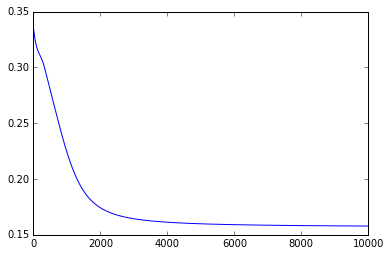

In [38]:
#verify MLP
nn = MLP([2, 10, 10, 2], activationFunction = "sigmoid")
trainX = np.array([[1, 4, 2, 1, 2, 4],
                  [1, 2, 2, 4, 3, 4]])
trainY = np.array([[0, 0, 0, 1, 1, 0],
                  [1, 1, 1, 0, 0, 1]])
nn.train(trainX, trainY, numEpoch=10000, lr=0.1, bs = 6)

plt.plot(nn.lossList[:])
print ("yHat is\n", nn.yHat)
print ("y is \n", trainY)
nn.layers[-1]["a"]

In [37]:
#data preprocess
train = pd.read_csv("titanic/train.csv")
train.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
# train.info()
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


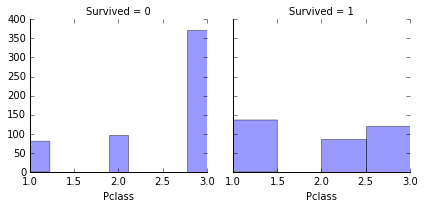

In [34]:
#data observation
# sns.countplot(train['Survived'])
# sns.countplot(train['Pclass'])
# sns.countplot(train['Age'])
# sns.countplot(train['SibSp'])
# sns.countplot(train['Parch'])
# sns.countplot(train['Fare'])

#各類資料與生存率的關係
# sns.countplot(train['Pclas'],hue=train['Survived'])

#Age v.s Survived
g = sns.FacetGrid(train, col='Survived')

g.map(sns.distplot, 'Pclass', kde=False)
# sns.countplot(train['Age'],hue=train['Survived'])


(891, 2)
yHat is
 [[1 0 0 0 0 1]
 [0 1 1 1 1 0]]
y is 
 [[0 0 0 1 1 0]
 [1 1 1 0 0 1]]


array([[  9.90e-01,   3.28e-03,   7.55e-04,   3.63e-03,   3.76e-03,
          9.98e-01],
       [  1.03e-02,   9.96e-01,   9.99e-01,   9.97e-01,   9.96e-01,
          2.19e-03]])

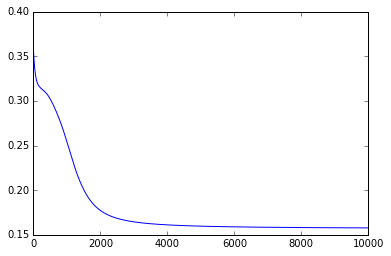

In [54]:
nn = MLP([2, 10, 10, 2], activationFunction = "sigmoid")
pclass = train['Pclass'].to_numpy()
age = train['Age'].to_numpy()
survived = train['Survived'].to_numpy()

trainX = np.column_stack( (pclass,age) )
# trainX = np.concatenate((pclass,age),axis=0) 

print(trainX.shape)
trainX = np.array([[1, 4, 2, 1, 2, 4],
                  [1, 2, 2, 4, 3, 4]])
trainY = np.array([[0, 0, 0, 1, 1, 0],
                  [1, 1, 1, 0, 0, 1]])

nn.train(trainX, trainY, numEpoch=10000, lr=0.1, bs = 6)

plt.plot(nn.lossList[:])
print ("yHat is\n", nn.yHat)
print ("y is \n", trainY)
nn.layers[-1]["a"]